In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pept import LineData, Pipeline, PointData
from pept.tracking import Stack, HDBSCAN, Cutpoints, SplitLabels, Centroids, Condition
from scipy.interpolate import interp1d
from skopt import gp_minimize
from skopt.space import Real, Integer
import sys
sys.path.append("/home/rayhaan/randomWalk_V3/Scripts/")
from interpolateTime import interpolateUnique
from tqdm import tqdm
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib widget

In [2]:
def errorCalculation(truePath: PointData, trackedPath: PointData) -> np.float64:
    fx = interp1d(truePath['t'], truePath['x'], fill_value = "extrapolate")
    fy = interp1d(truePath['t'], truePath['y'], fill_value = "extrapolate")
    fz = interp1d(truePath['t'], truePath['z'], fill_value = "extrapolate")

    xInterp = fx(trackedPath['t'])
    yInterp = fy(trackedPath['t'])
    zInterp = fz(trackedPath['t'])

    errorX = np.sum(np.abs(xInterp - trackedPath['x']))/len(xInterp)
    errorY = np.sum(np.abs(yInterp - trackedPath['y']))/len(xInterp)
    errorZ = np.sum(np.abs(zInterp - trackedPath['z']))/len(xInterp)

    combinedError = np.sqrt(errorX**2 + errorY**2 + errorZ**2)

    return combinedError

In [65]:
def loadTruePath(path: str) -> PointData:
    data = np.loadtxt(path, skiprows = 3)
    points = np.array([data[:, 0], data[:, 5], data[:, 6], data[:, 7]]).T
    pData = PointData(points)
    return pData

def loadData(path: str) -> LineData:
    lines = np.load(path)
    rawLines = np.array([lines[:, 6], lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3], lines[:, 4], lines[:, 5]]).T
    lData = LineData(rawLines)
    return lData

In [162]:
trueData = loadTruePath(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_0.1mm_Varying_Tau_0.08_1.20ms/Placements/RW3_TS_0.60ms_SS_0.10mm.placements")
lors = loadData(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_0.1mm_Varying_Tau_0.08_1.20ms/Lines_NPY/RW3_TS_0.60ms_SS_0.10mm.npy")

In [163]:
times = lors['t']
newTime = interpolateUnique(msTime = times)
lors_2 = LineData(np.c_[newTime, lors.lines[:, 1:7]])

In [164]:
MLPipe = Pipeline([
            Stack(sample_size = 200, overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = 0.1),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = 0.6),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [165]:
locTest = MLPipe.fit(lors_2)
print("The location rate is {} Hz".format(len(locTest.points)/0.5))

Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 840/840 [00:00<00:00, 1500.89it/s]



Processed samples in 4.7403342723846436 s

The location rate is 1558.0 Hz


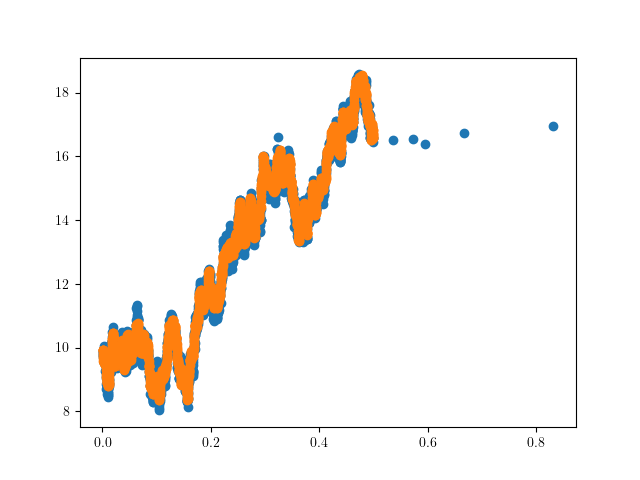

In [87]:
plt.close("all")
fig, ax = plt.subplots(1, 1)
ax.scatter(locTest['t'], locTest['x'])
ax.scatter(trueData['t'], trueData['x'])



In [33]:
# filter2 = Condition("t >= 0.0, t <= 0.5") + Stack()
# locTest2 = filter2.fit(locTest)a

In [59]:
# np.save("/home/rayhaan/randomWalk_V3/Plots/truePath", arr = trueData.points)

In [390]:
# plt.close("all")
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (7, 5), sharex = "col")

# fig.suptitle("TS_0.4ms_Lambda_2.0mm_L_245.954kHz")
# ax1.scatter(locTest2['t'], locTest2['x'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax1.plot(trueData['t'], trueData['x'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax2.scatter(locTest2['t'], locTest2['y'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax2.plot(trueData['t'], trueData['y'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax3.scatter(locTest2['t'], locTest2['z'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax3.plot(trueData['t'], trueData['z'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax1.legend()
# ax2.legend()
# ax3.legend()

# ax3.set_xlabel("t (s)")

# ax1.set_ylabel("X (mm)")
# ax2.set_ylabel("Y (mm)")
# ax3.set_ylabel("Z (mm)")

# fig.tight_layout()
# fig.savefig("/home/rayhaan/randomWalk_V3/Plots/Test_Extreme_OL1.png", dpi = 300)




In [166]:
def optAllML(lowerLocRate, upperLocRate, Data, truePath):

    # out = []

# for i in tqdm(range(len(UsedSampleSizes)-1)):
    def ObjectiveML(x):
        MLPipe = Pipeline([
            Stack(sample_size = x[0], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = x[1]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = x[2]),
            SplitLabels() + Centroids(),
            Stack()
        ])

        locs = MLPipe.fit(Data, verbose = True)

        locRate = len(locs.points)/0.5

        error = errorCalculation(truePath = truePath, trackedPath = locs)

        if (locRate >= lowerLocRate) and (locRate <= upperLocRate):
            error = error
        else:
            error = 10000 + error

        print("The error is: {} mm, the location rate is: {} kHz".format(error, locRate))

        return error

    space = [Integer(190, 210, name = 'SS1'),
            # Real(1.0, 3.0, name = 'MD'),
            Real(0.1, 0.6, name = 'TF1'),
            Real(0.55, 0.65, name = 'TF2'),
                    ]

    res = gp_minimize(ObjectiveML, space, n_calls = 20, verbose = True, random_state = 657333)

    out1 = [res.fun, res.x[0], res.x[1], res.x[2]]

    return out1

In [167]:
1/(0.60e-3)

1666.6666666666667

In [168]:
lowerLocRate = 1300
upperLocRate = 1900


In [169]:
optVals = optAllML(lowerLocRate = lowerLocRate, upperLocRate = upperLocRate, Data = lors_2, truePath = trueData)

Iteration No: 1 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [00:00<00:00, 1519.14it/s]



Processed samples in 7.038108587265015 s

The error is: 0.1747271869576973 mm, the location rate is: 1628.0 kHz
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.0424
Function value obtained: 0.1747
Current minimum: 0.1747
Iteration No: 2 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 735/735 [00:00<00:00, 1288.70it/s]



Processed samples in 22.114798307418823 s

The error is: 0.17595684754429866 mm, the location rate is: 1364.0 kHz
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 22.1194
Function value obtained: 0.1760
Current minimum: 0.1747
Iteration No: 3 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 855/855 [00:00<00:00, 1539.99it/s]



Processed samples in 5.022283554077148 s

The error is: 10000.209487596796 mm, the location rate is: 208.0 kHz
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.0262
Function value obtained: 10000.2095
Current minimum: 0.1747
Iteration No: 4 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 867/867 [00:00<00:00, 1470.02it/s]



Processed samples in 4.91775107383728 s

The error is: 10000.3870000328 mm, the location rate is: 192.0 kHz
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.9210
Function value obtained: 10000.3870
Current minimum: 0.1747
Iteration No: 5 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 821/821 [00:00<00:00, 1310.40it/s]



Processed samples in 21.411447286605835 s

The error is: 10000.211452530877 mm, the location rate is: 190.0 kHz
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 21.4152
Function value obtained: 10000.2115
Current minimum: 0.1747
Iteration No: 6 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 1163.91it/s]



Processed samples in 5.589881181716919 s

The error is: 10000.18692465542 mm, the location rate is: 176.0 kHz
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 5.5944
Function value obtained: 10000.1869
Current minimum: 0.1747
Iteration No: 7 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 870/870 [00:00<00:00, 1500.64it/s]



Processed samples in 14.65141224861145 s

The error is: 0.18299845605799628 mm, the location rate is: 1630.0 kHz
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 14.6555
Function value obtained: 0.1830
Current minimum: 0.1747
Iteration No: 8 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 818/818 [00:00<00:00, 1399.03it/s]



Processed samples in 23.027652502059937 s

The error is: 10000.189338920032 mm, the location rate is: 222.0 kHz
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 23.0321
Function value obtained: 10000.1893
Current minimum: 0.1747
Iteration No: 9 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 815/815 [00:00<00:00, 1370.43it/s]



Processed samples in 23.71859121322632 s

The error is: 10000.194123316249 mm, the location rate is: 176.0 kHz
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 23.7241
Function value obtained: 10000.1941
Current minimum: 0.1747
Iteration No: 10 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 817/817 [00:00<00:00, 1293.07it/s]



Processed samples in 21.784579277038574 s

The error is: 10000.194239749611 mm, the location rate is: 204.0 kHz
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 22.0698
Function value obtained: 10000.1942
Current minimum: 0.1747
Iteration No: 11 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 847/847 [00:01<00:00, 616.66it/s]



Processed samples in 10.34363055229187 s

The error is: 0.1669918857876315 mm, the location rate is: 1558.0 kHz
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 10.6857
Function value obtained: 0.1670
Current minimum: 0.1670
Iteration No: 12 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 877/877 [00:00<00:00, 1578.11it/s]



Processed samples in 7.066464900970459 s

The error is: 0.17453658245060322 mm, the location rate is: 1660.0 kHz
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 7.4315
Function value obtained: 0.1745
Current minimum: 0.1670
Iteration No: 13 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 1501.15it/s]



Processed samples in 14.416066408157349 s

The error is: 0.18241127864780757 mm, the location rate is: 1612.0 kHz
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 14.8355
Function value obtained: 0.1824
Current minimum: 0.1670
Iteration No: 14 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 869/869 [00:00<00:00, 1525.27it/s]



Processed samples in 14.314802169799805 s

The error is: 0.18160655028299225 mm, the location rate is: 1620.0 kHz
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 14.6797
Function value obtained: 0.1816
Current minimum: 0.1670
Iteration No: 15 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 871/871 [00:00<00:00, 1640.78it/s]



Processed samples in 14.313982486724854 s

The error is: 0.18298592926740456 mm, the location rate is: 1620.0 kHz
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 14.7628
Function value obtained: 0.1830
Current minimum: 0.1670
Iteration No: 16 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 415/415 [00:00<00:00, 4921.22it/s]



Processed samples in 23.146421670913696 s

The error is: 10000.198302191076 mm, the location rate is: 760.0 kHz
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 23.4659
Function value obtained: 10000.1983
Current minimum: 0.1670
Iteration No: 17 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 797/797 [00:00<00:00, 1555.76it/s]



Processed samples in 22.141867637634277 s

The error is: 0.17391006541265042 mm, the location rate is: 1490.0 kHz
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 22.5612
Function value obtained: 0.1739
Current minimum: 0.1670
Iteration No: 18 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 805/805 [00:00<00:00, 1413.88it/s]



Processed samples in 22.191139698028564 s

The error is: 0.17346009371428708 mm, the location rate is: 1502.0 kHz
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 22.5746
Function value obtained: 0.1735
Current minimum: 0.1670
Iteration No: 19 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 809/809 [00:00<00:00, 1550.29it/s]



Processed samples in 22.41327166557312 s

The error is: 0.17468192265972488 mm, the location rate is: 1510.0 kHz
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 22.8512
Function value obtained: 0.1747
Current minimum: 0.1670
Iteration No: 20 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 870/870 [00:00<00:00, 1568.66it/s]



Processed samples in 20.26559567451477 s

The error is: 0.16985873724860728 mm, the location rate is: 1650.0 kHz
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 20.6626
Function value obtained: 0.1699
Current minimum: 0.1670


In [170]:
optVals

[0.1669918857876315, 199, 0.2626277848472861, 0.6290793407347709]

In [171]:
MLPipeOpt = Pipeline([
            Stack(sample_size = optVals[1], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = optVals[2]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = optVals[3]),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [172]:
optLocs = MLPipeOpt.fit(lors_2)
print("The location rate is {:.2f} Hz".format(len(optLocs.points)/0.5))

Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 854/854 [00:00<00:00, 1512.35it/s]



Processed samples in 9.957148551940918 s

The location rate is 1588.00 Hz


In [173]:
optLocs

pept.PointData (samples: 854)
-----------------------------
sample_size = [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1

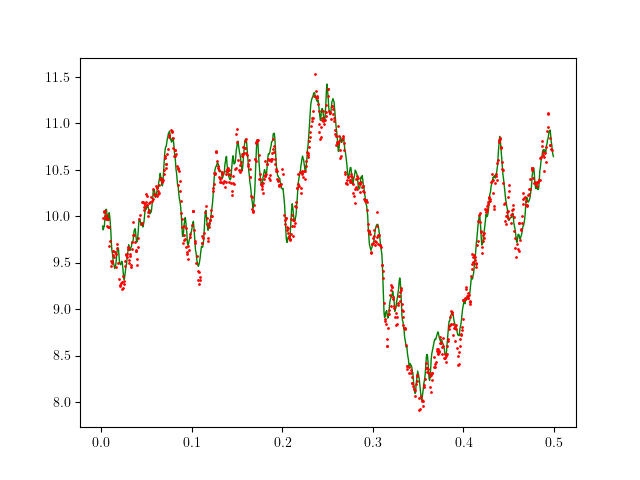

In [174]:
plt.close("all")
fig, ax = plt.subplots(1, 1)

ax.scatter(optLocs['t'], optLocs['x'], color = 'r', s = 1, zorder = 1)
ax.plot(trueData['t'], trueData['x'], color = 'g', lw = 1, zorder = 0)

In [175]:
filter1 = Condition("t >= 0.0, t <= 0.5") + Stack()
filteredLocs = filter1.fit(optLocs)

Batch 1 / 1 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 854/854 [00:00<00:00, 1505.38it/s]



Processed samples in 0.9460427761077881 s



In [176]:
np.save("/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_0.1mm_Varying_Tau_0.08_1.20ms/tracks/RW3_TS_0.60ms_SS_0.10mm", arr = filteredLocs.points)

In [177]:
uncertainty = errorCalculation(truePath = trueData, trackedPath = optLocs)

In [178]:
print("The uncertainty is {} mm".format(uncertainty))

The uncertainty is 0.16099757395157516 mm


In [5]:
optimVals = np.loadtxt("/home/rayhaan/randomWalk_V3/Notebooks/opt_Sigma_2.0mm.csv", skiprows = 2, delimiter = ", ")

In [6]:
taus = optimVals[:, 0]
deltaR = optimVals[:, 4]

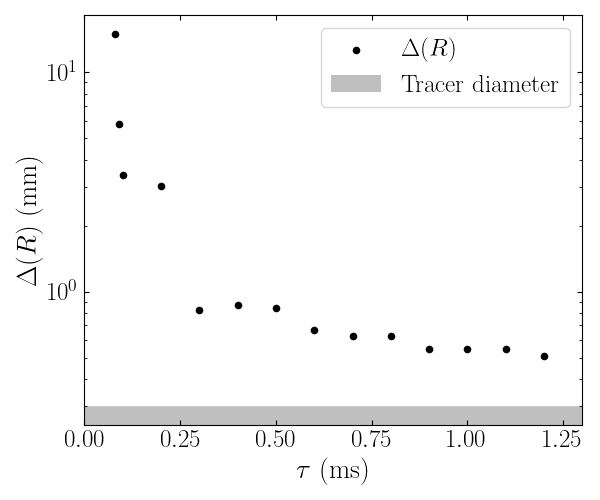

In [29]:
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize = (6, 5))
s = 20


fillx = np.linspace(0.0, 1.3, 1000)
filly = np.repeat(0.3, len(fillx))

ax.scatter(taus, deltaR, s = 20, color = 'k', label = r"$\Delta(R)$")
ax.fill_between(fillx, filly,  facecolor = 'k', alpha = 0.25, label = r"Tracer diameter", edgecolor = "None")

ax.set_xlabel(r"$\tau$ (ms)", fontsize = s)
ax.set_ylabel(r"$\Delta(R)$ (mm)", fontsize = s)

ax.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
ax.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)

ax.legend(loc = "upper right", fontsize = s - 2)

ax.tick_params(axis="x", labelsize = s - 2) 
ax.tick_params(axis="y", labelsize = s - 2)
ax.set_yscale("log")

ax.set_xlim(0.0, 1.3)
# ax.set_ylim(0.0, 16)
fig.tight_layout()

fig.savefig("/home/rayhaan/randomWalk_V3/Plots/tau_deltaR_Lambda_2.0mm.png", dpi = 300)